# Selecting Categorical Features

The purpose of this notebook is to determine which categorical features to keep.  

I take a simplistic approach and see if there are differences in charge-off rate for the different values of each of the categorical variables.

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

## Reading-In the Data

In [2]:
df_default = pd.read_csv("data_processed/01_binary_training.csv", low_memory=False)

## Identifying Categorical Variables

In [3]:
lst_categorical = sorted(list(df_default.columns[df_default.dtypes=='object']))
lst_categorical

['addr_state',
 'application_type',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'initial_list_status',
 'purpose',
 'sub_grade',
 'term',
 'title',
 'verification_status',
 'zip_code']

## Checking Base-Rates

As we can see, about 20% of the loand defaulted in our training set, and about 21.6% of the total loan amount was defaulted.

In [4]:
df_default['charged_off'].mean()

0.1998023555985802

In [5]:
np.sum(df_default['charged_off'] * df_default['loan_amnt'])

2930991650.0

In [6]:
np.sum(df_default['charged_off'] * df_default['loan_amnt']) / np.sum(df_default['loan_amnt'])

0.21571385960013328

## Individual Analysis of Categorical Variables

### `addr_state` (drop - high cardinality and some states have low representation, e.g. IA)

There seems to be high variability, but also high cardinality.  In the future, could try to create regions to consolidate this data into a lower cardinality feature.

In [7]:
df_default['addr_state'].value_counts()

addr_state
CA    137703
TX     77001
NY     76969
FL     66911
IL     36288
NJ     33920
PA     31750
OH     30811
GA     30304
VA     26680
NC     26520
MI     24610
AZ     22823
MD     21823
MA     21678
CO     20776
WA     20551
MN     16814
IN     15204
MO     14822
TN     14326
NV     14226
CT     13770
WI     12455
OR     11572
AL     11454
SC     11224
LA     10835
KY      9115
OK      8569
KS      7880
UT      7094
AR      7090
NM      5120
HI      4747
MS      4528
NH      4515
RI      4080
WV      3462
MT      2691
DE      2669
NE      2484
DC      2469
AK      2232
WY      2047
SD      1943
VT      1822
ME      1402
ID      1186
ND      1127
IA         4
Name: count, dtype: int64

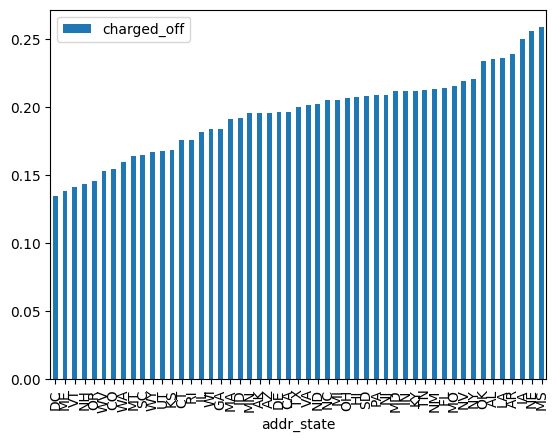

In [8]:
df_default.groupby(['addr_state'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

### `application_type` (drop)

Directionally it doesn't make sense and the joint app pool is very small, so might be dealing with a small $n$ problem.

In [9]:
df_default['application_type'].value_counts()

application_type
Individual    924021
Joint App      18075
Name: count, dtype: int64

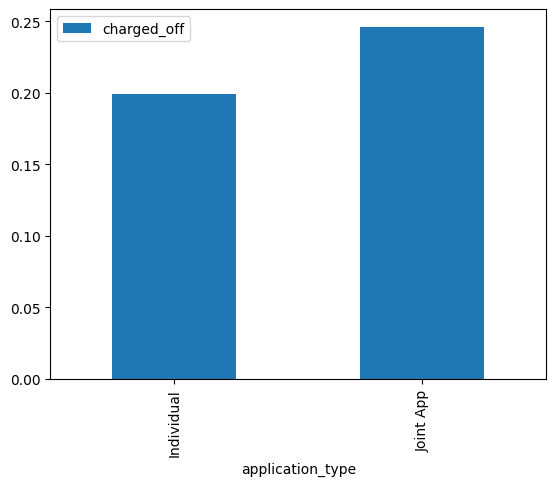

In [10]:
df_default.groupby(['application_type'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

### `earliest_cr_line` - Convert to year and keep

There is a clear pattern of young and old borrowers tend to default.

In [11]:
df_default['earliest_cr_line'].value_counts()

earliest_cr_line
Aug-2001    6571
Aug-2002    6362
Sep-2003    6318
Oct-2001    6291
Sep-2004    6190
            ... 
Jan-1950       1
Feb-1945       1
Oct-1957       1
Jan-1944       1
May-1950       1
Name: count, Length: 728, dtype: int64

In [12]:
np.int64(df_default['earliest_cr_line'].str[-4:])

array([1996, 1990, 2001, ..., 2004, 2001, 2000])

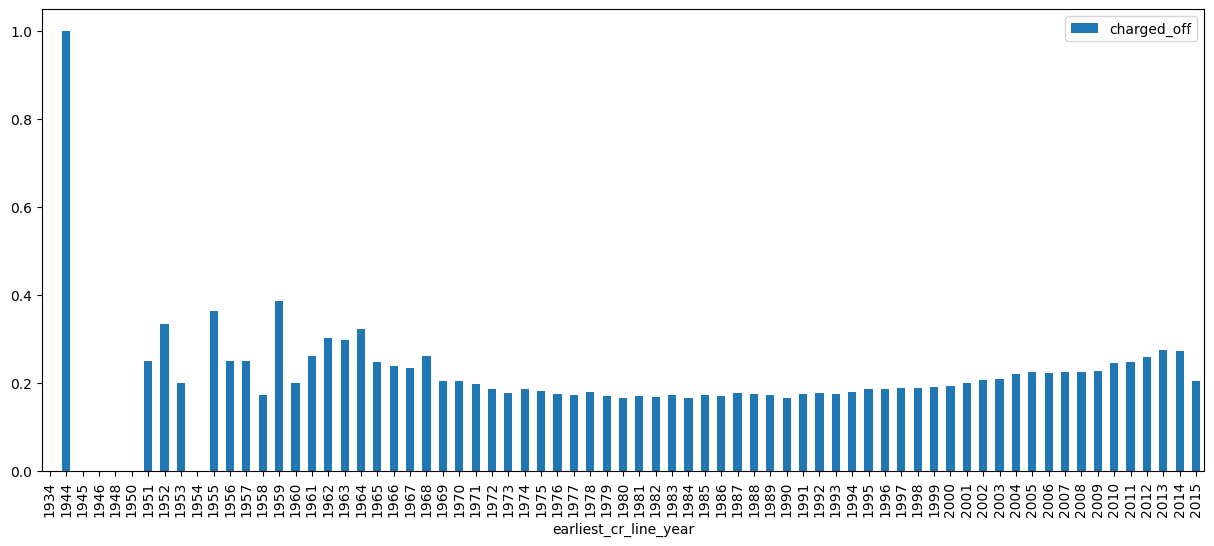

In [13]:
df_test = pd.DataFrame({'earliest_cr_line_year':np.int64(df_default['earliest_cr_line'].str[-4:]), 'charged_off':df_default['charged_off']})
df_test.groupby(['earliest_cr_line_year'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off', figsize=(15,6));

### `emp_length` (drop)

Doesn't seem to make a difference so let's drop.

In [14]:
df_default['emp_length'].value_counts()

emp_length
10+ years    310030
2 years       85200
< 1 year      75742
3 years       75114
1 year        62024
5 years       58960
4 years       56515
6 years       43766
8 years       42424
7 years       41626
9 years       35674
Name: count, dtype: int64

Let's map these values to integers so they are easier to graph.

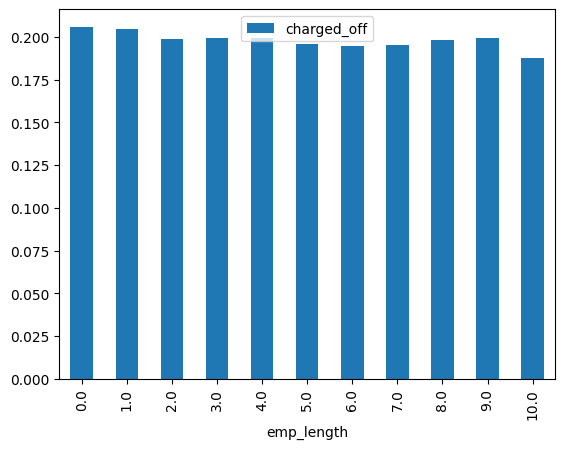

In [15]:
scale_mapper = \
{'< 1 year':0,
'1 year':1,
'2 years':2,
'3 years':3,
'4 years':4,
'5 years':5,
'6 years':6,
'7 years':7,
'8 years':8,
'9 years':9,
'10+ years':10}

df_test = pd.DataFrame({'emp_length':df_default['emp_length'].replace(scale_mapper), 'charged_off':df_default['charged_off']})
df_test.groupby(['emp_length'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `emp_title` (drop)

This looks like a free text and there are way too many values, so I am going to drop this.

In [16]:
df_default['emp_title'].value_counts()

emp_title
Teacher                             14803
Manager                             13584
Owner                                7166
Registered Nurse                     6175
RN                                   5976
                                    ...  
Graphic/Web Work                        1
Linfield Christian Schools              1
Capacity Manager/Current Planner        1
Health Tech.                            1
table gaming, dual supervisor           1
Name: count, Length: 284235, dtype: int64

### `grade` (keep)

In [18]:
df_default["grade"].value_counts()

grade
B    275040
C    267146
A    164855
D    140609
E     65485
F     22497
G      6464
Name: count, dtype: int64

Clearly the loan grade is related to chargeoff rate.

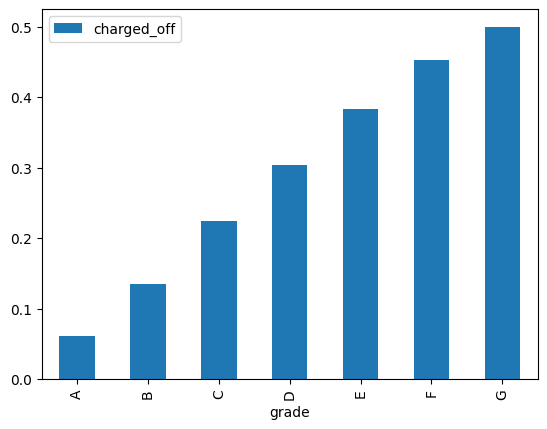

In [17]:
%matplotlib inline
df_default.groupby(['grade'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `home_ownership` (keep)

As we can see, there are very few `ANY`, `OTHER`, `NONE`,  so let's just replace those with the most prevalent class which is `MORTGAGE`. **Use a pipeline for this.**

In [19]:
df_default['home_ownership'].value_counts()

home_ownership
MORTGAGE    465753
RENT        374452
OWN         101553
ANY            199
OTHER          110
NONE            29
Name: count, dtype: int64

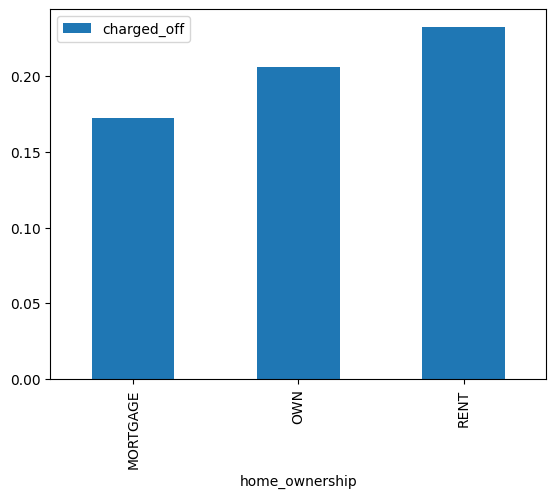

In [20]:
ownership_mapper = \
{'MORTGAGE':'MORTGAGE',
'RENT':'RENT',
'OWN':'OWN',
'ANY':'MORTGAGE',
'OTHER':'MORTGAGE',
'NONE':'MORTGAGE',}

df_test = pd.DataFrame({'home_ownership':df_default['home_ownership'].replace(ownership_mapper), 'charged_off':df_default['charged_off']})
df_test.groupby(['home_ownership'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

Renters tend to have higher default rates which makes sense.  It seems weird that `OWN` would have a higher charge-off rate that `MORTGAGE`.  Not sure how to interpret that.

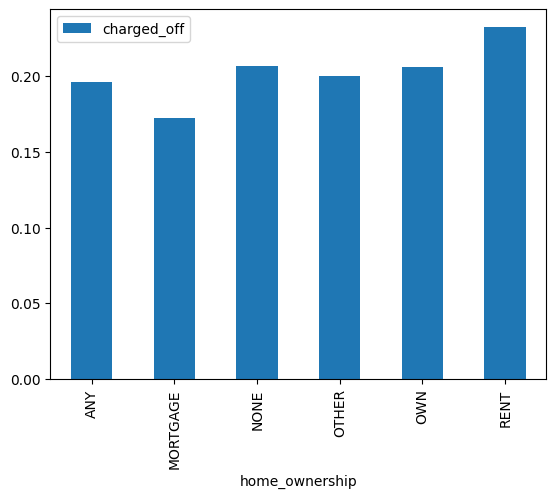

In [21]:
df_default.groupby(['home_ownership'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `initial_list_status` (drop)

No difference.

In [22]:
df_default['initial_list_status'].value_counts()

initial_list_status
w    548857
f    393239
Name: count, dtype: int64

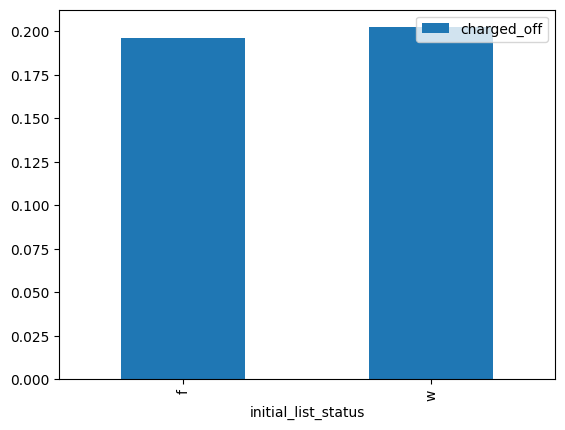

In [23]:
df_default.groupby(['initial_list_status'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

### `purpose` (keep)

There seems to be a lot of variabilty in the default rate by purpose of the loan.  **Maybe get rid of the categories that only have a few entries, perhaps create an other category.**

In [24]:
df_default['purpose'].value_counts() 

purpose
debt_consolidation    546460
credit_card           206767
home_improvement       61414
other                  54458
major_purchase         20589
medical                10906
small_business         10842
car                    10108
moving                  6653
vacation                6278
house                   5113
wedding                 1595
renewable_energy         661
educational              252
Name: count, dtype: int64

In [25]:
df_default['purpose'].value_counts() / df_default['purpose'].shape[0]

purpose
debt_consolidation    0.580047
credit_card           0.219476
home_improvement      0.065189
other                 0.057805
major_purchase        0.021854
medical               0.011576
small_business        0.011508
car                   0.010729
moving                0.007062
vacation              0.006664
house                 0.005427
wedding               0.001693
renewable_energy      0.000702
educational           0.000267
Name: count, dtype: float64

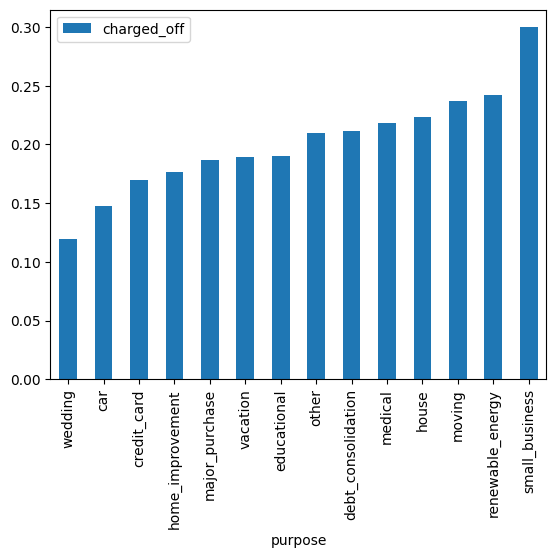

In [26]:
df_default.groupby(['purpose'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

### `sub_grade` (keep)

Clearly the `sub_grade` is related to `charged_off` rate.  Can probably drop `grade` in favor of `sub_grade`.

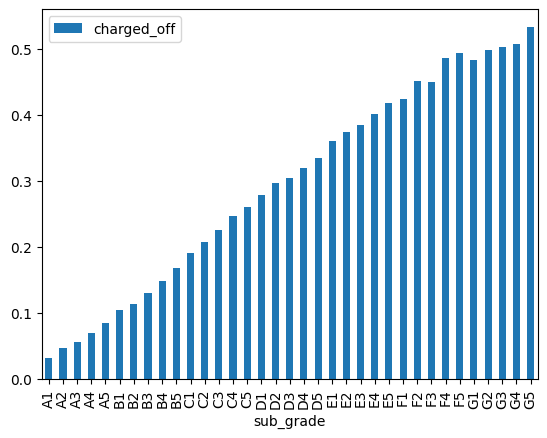

In [27]:
df_default.groupby(['sub_grade'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `term` (keep)

In [28]:
df_default['term'].value_counts()

term
 36 months    714669
 60 months    227427
Name: count, dtype: int64

The default rate for 60 month loans seems to be quite a bit higher, so let's keep this.

In [29]:
df_default.groupby(['term'])['charged_off'].agg(np.mean)

term
 36 months    0.160381
 60 months    0.323682
Name: charged_off, dtype: float64

### `title` (drop)

Seems like a more free-form version of purpose.  Lots of values so drop.

In [30]:
df_default['title'].value_counts()

title
Debt consolidation                      462738
Credit card refinancing                 174962
Home improvement                         52731
Other                                    46705
Major purchase                           16866
                                         ...  
Car work                                     1
DAMAGE CONTROL                               1
Oral Surgery                                 1
High Interest Debts Consolidation            1
Home Improvement/ Debt consolidation         1
Name: count, Length: 45410, dtype: int64

### `verification_status` (keep)

There seems to be differences in charged off rates, but it seems kind of weird to me that `verified` had a higher charge-off rate than `not verified`.  In any case we'll keep it.

In [31]:
df_default['verification_status'].value_counts()

verification_status
Source Verified    364751
Verified           292897
Not Verified       284448
Name: count, dtype: int64

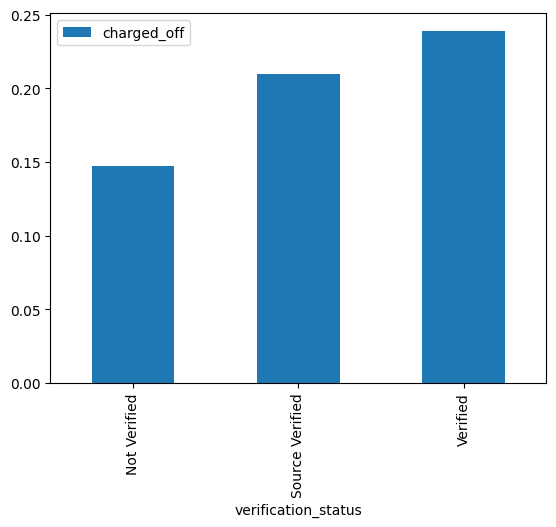

In [32]:
df_default.groupby(['verification_status'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `zip_code` (drop)

There seems to be quite a bit of variability, but the data is too granular to work with.  This is to some extent covered by `addr_state`.

In [33]:
df_default['zip_code'].value_counts()

zip_code
945xx    10458
750xx    10097
112xx     9626
606xx     8768
300xx     8478
         ...  
555xx        1
643xx        1
552xx        1
896xx        1
525xx        1
Name: count, Length: 931, dtype: int64

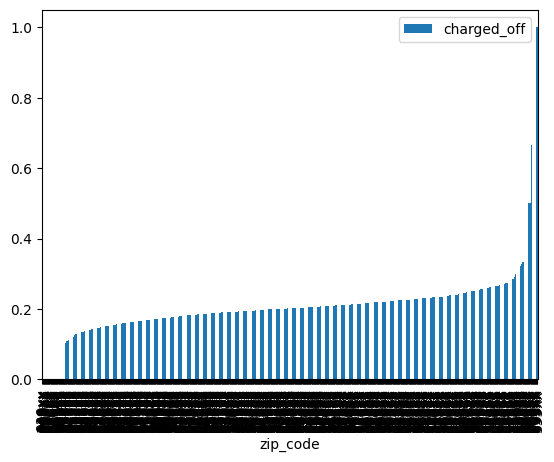

In [34]:
df_default.groupby(['zip_code'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

## Variables to Keep

In [ ]:
[
#'addr_state',
#'application_type',
'earliest_cr_line', # convert to year
#'emp_length', #
#'emp_title',
'grade',
'home_ownership', # need to modify any, other categories
#'initial_list_status', 
'purpose', # need to create an other category
'sub_grade',
'term',
# 'title',
'verification_status',
# 'zip_code'
]

## OLD CODE

In [ ]:
# to_drop = \
# ['emp_title',
#  'emp_length',
#  'issue_d',
#  'pymnt_plan',
#  'url',
#  'title',
#  'zip_code',
#  'initial_list_status',
#  'last_pymnt_d',
#  'last_credit_pull_d',
#  'application_type',
#  'hardship_flag',
#  'disbursement_method',
#  'debt_settlement_flag']

In [ ]:
# df_default.drop(columns=to_drop, inplace=True)

In [ ]:
# df_default['earliest_cr_line'] = np.int64(df_default['earliest_cr_line'].str[-4:])

In [ ]:
# df_default

In [ ]:
# pd.options.display.max_rows = 100

In [ ]:
# df_default.dtypes

In [ ]:
# df_default.to_csv('data_processed/03_categorical_processed.csv', index=False)

In [ ]:
# lst_categorical = sorted(list(df_default.columns[df_default.dtypes=='object']))
# lst_categorical